# Анализ данных книги ордеров

## Импорт библиотек и стартовые настройки

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show
from scipy.stats import normaltest

In [2]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

In [18]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'AAPL'
date = '20191030'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

## Загрузка данных системных событий

In [4]:
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code').drop_duplicates()
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

## Сводка по сделкам

In [5]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8887 entries, 0 to 8886
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   stock_locate                    8887 non-null   int64          
 1   tracking_number                 8887 non-null   int64          
 2   timestamp                       8887 non-null   timedelta64[ns]
 3   stock                           8887 non-null   object         
 4   market_category                 8887 non-null   object         
 5   financial_status_indicator      8887 non-null   object         
 6   round_lot_size                  8887 non-null   int64          
 7   round_lots_only                 8887 non-null   object         
 8   issue_classification            8887 non-null   object         
 9   issue_sub_type                  8887 non-null   object         
 10  authenticity                    8887 non-null   object      

Основной объем сделок приходиться на небольшое количество бугам из 8887 акций, торгуемых в этот день

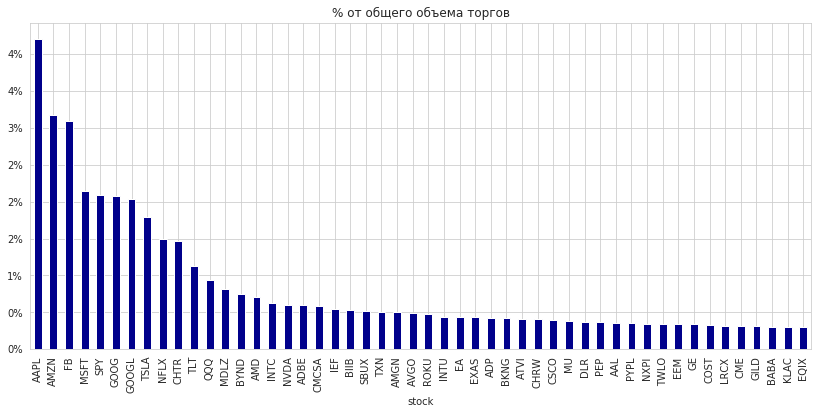

In [6]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% от общего объема торгов')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## Сводка по AAPL

In [7]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']

In [8]:
trades.price = trades.price.mul(1e-4) #форматируем цену
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58713 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 15:59:59.979015439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   shares  58713 non-null  int64  
 1   price   58713 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


## Тики


Тиковые данные предоставляются каждую наносекунду и очень зашумлены. Скачки BID и ASK, например, заставляют цену колебаться между значениями спроса и предложения, когда возникают новые сделки. Чтобы  улучшить статистические свойства и повысить соотношение сигнала к шуму нам необходимо упорядочить тиковые данные путем агрегирования торговой активности. 

Агрегирование производится объединением данных в значения открытия, минимальной, максимальной и цены закрыти (Open, Low, High, Close - OLHC) за выбранных период времени, а также [средневзвешенной цены объема](https://fx-wiki.ru/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B2%D0%B7%D0%B2%D0%B5%D1%88%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D1%86%D0%B5%D0%BD%D0%B0_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BC%D0%B0#:~:text=%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%B2%D0%B7%D0%B2%D0%B5%D1%88%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F%20%D1%86%D0%B5%D0%BD%D0%B0%20%D0%BE%D0%B1%D1%8A%D0%B5%D0%BC%D0%B0%20(Volume%20Weighted,%D1%82%D0%BE%D1%80%D0%B3%D0%BE%D0%B2%20%D0%B7%D0%B0%20%D0%BE%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D0%B9%20%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%BC%D0%B5%D0%B6%D1%83%D1%82%D0%BE%D0%BA) ) (Volume Weighted Average Price - VWAP), количества сделок и временой отметки. 

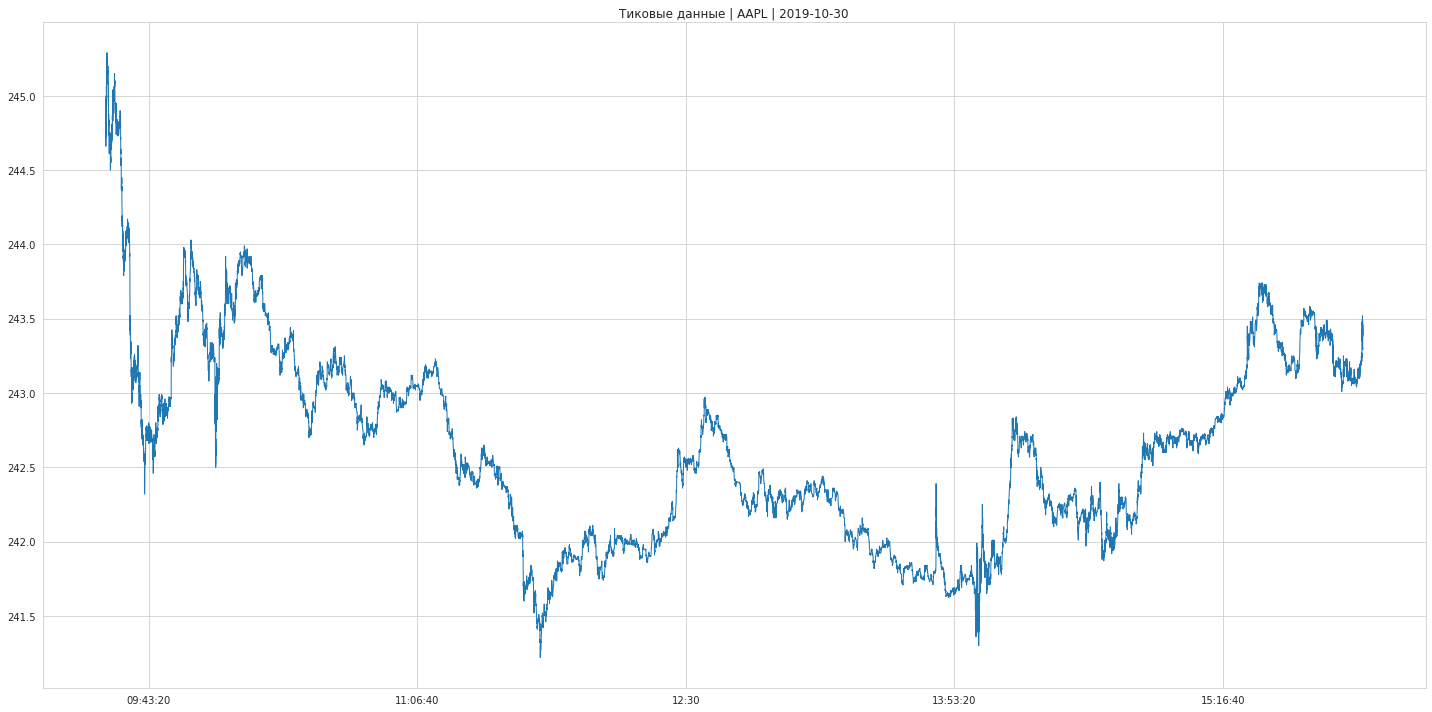

In [9]:
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(20, 10), 
                     title=f'Тиковые данные | {title}', lw=1)
plt.xlabel('')
plt.tight_layout();

Тест номальности тиковых данных

In [10]:
normaltest(tick_bars.price.pct_change().dropna())

NormaltestResult(statistic=20684.40456159484, pvalue=0.0)

## Регулязация тиковых данных

### График цены и объема

Функция price_volume() используется для сравнения соотношений цена-объем для различных методов регулязации

In [29]:
def price_volume(df, price='vwap', vol='vol', subtitle=title):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(30, 15))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(10*len(df.index)), color='r')
    
    #форматирование
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Цена', fontsize=14)
    axes[1].set_title('Объем', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(subtitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9);

Получение аргегированных данных с помощью get_bar_stats()

In [12]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

### Time bars

Time bars описываю объем в определенный интервал времени

In [57]:
time_frame = '1Min'
resampled = trades.groupby(pd.Grouper(freq=time_frame))
time_bars = get_bar_stats(resampled)
print(time_bars)
normaltest(time_bars.vwap.pct_change().dropna())

                      open   high    low  close   vwap     vol   txn
timestamp                                                           
2019-10-30 09:30:00 244.83 245.29 244.66 244.84 244.94   73526   712
2019-10-30 09:31:00 244.81 244.81 244.50 244.77 244.68   31167   361
2019-10-30 09:32:00 244.74 245.15 244.70 244.90 244.97   28473   414
2019-10-30 09:33:00 244.93 244.95 244.73 244.74 244.83   16243   262
2019-10-30 09:34:00 244.78 244.90 244.37 244.45 244.71   29686   265
...                    ...    ...    ...    ...    ...     ...   ...
2019-10-30 15:55:00 243.19 243.23 243.08 243.13 243.15   44951   423
2019-10-30 15:56:00 243.12 243.17 243.05 243.08 243.11   36502   395
2019-10-30 15:57:00 243.08 243.16 243.05 243.06 243.08   59923   564
2019-10-30 15:58:00 243.06 243.17 243.04 243.14 243.11   63524   599
2019-10-30 15:59:00 243.14 243.52 243.10 243.30 243.29  122635  1204

[390 rows x 7 columns]


NormaltestResult(statistic=65.70387182967823, pvalue=5.402384769537968e-15)

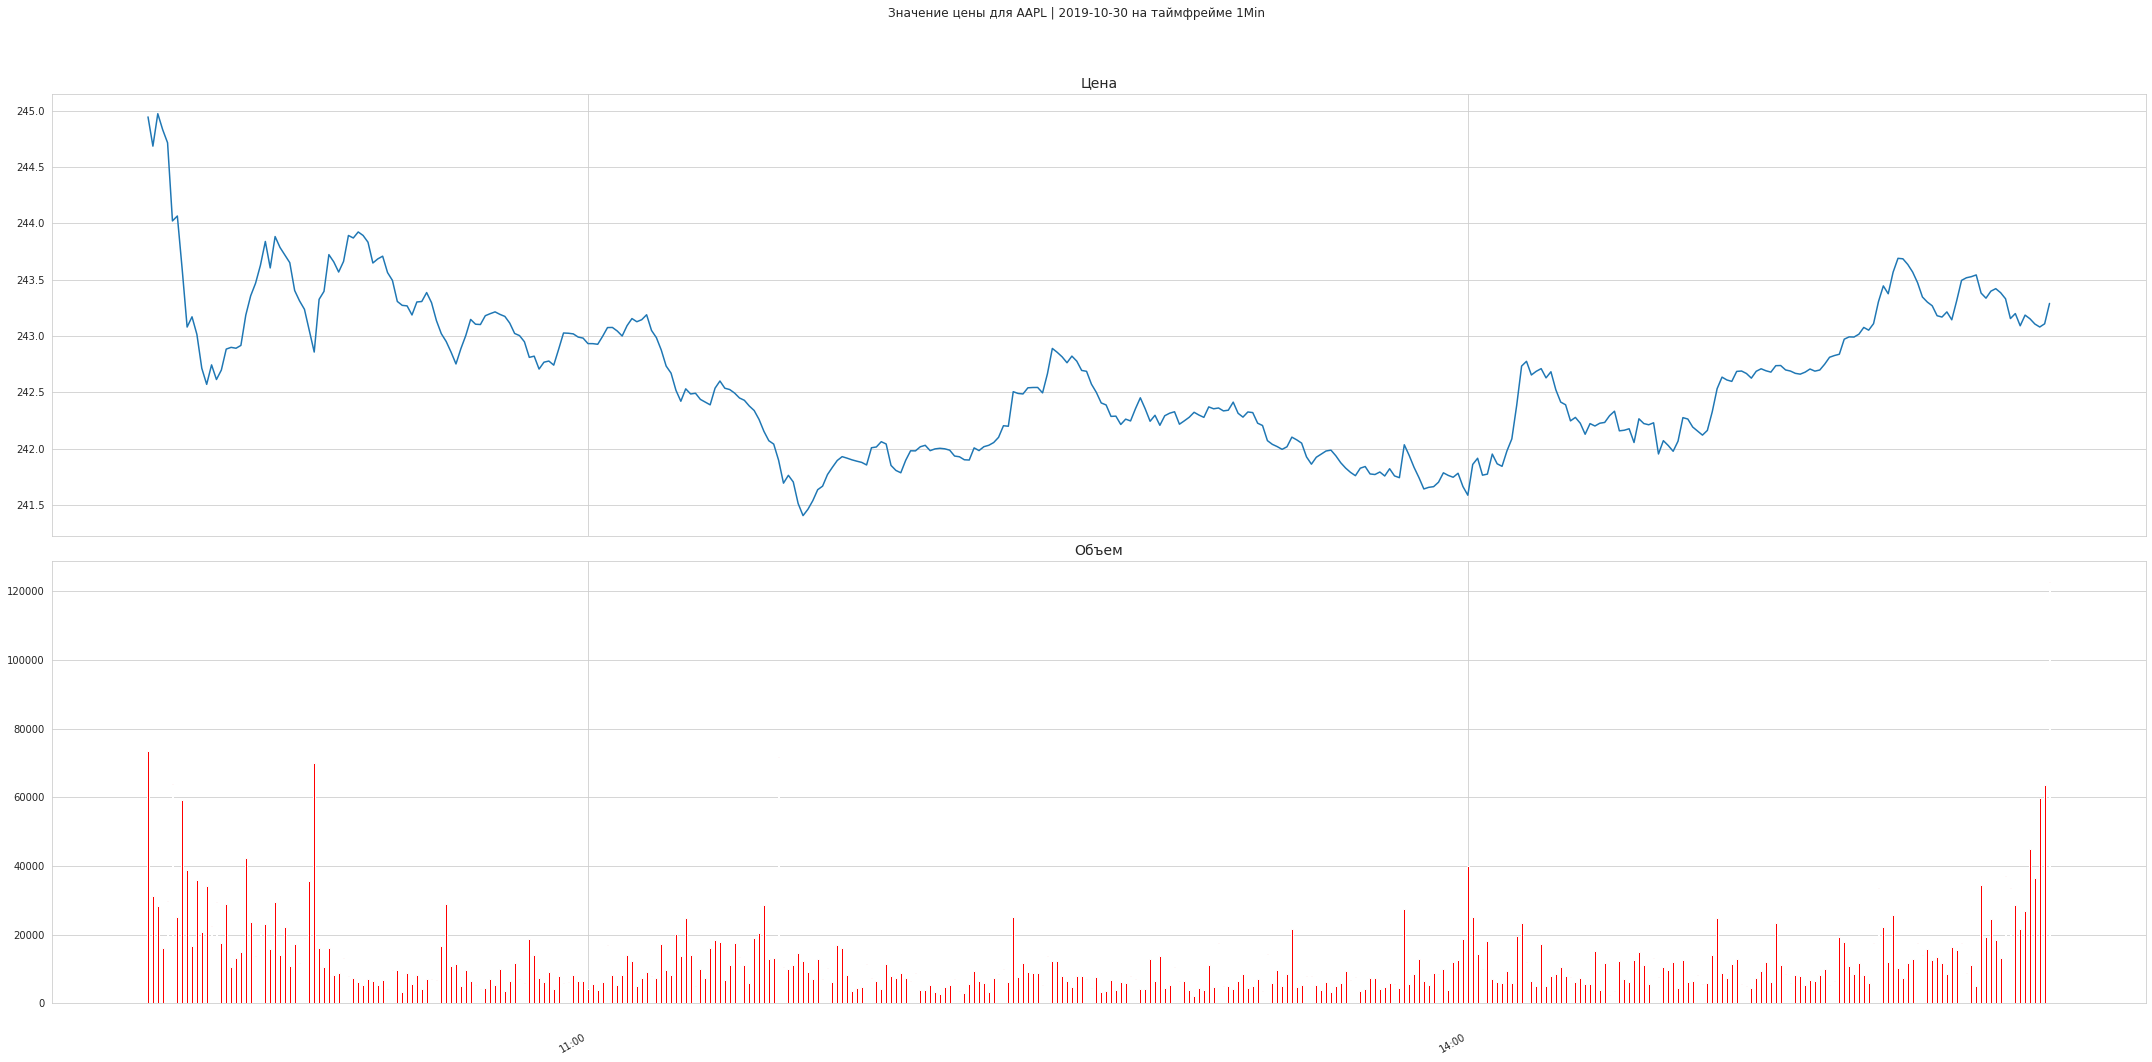

In [30]:
price_volume(time_bars, subtitle=f'Time Bars | {title} | на таймфрейме {time_frame}')

### Volume bar

Алгоритмическая торговля, основаная на сопоставлении средневзвещенной цены объема и выбранного периода, будет делить один ордер на несколько сделок и размещать их в книге ордеров, на основе историчиских паттернов.
TIme bars могут обрабатывать один и то же ордер по разнаному, даже в отстутствии поступления какой-либо новой информации.

Volume bars - агрегирование данных на основании объемов.

In [34]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades

,shares,price
timestamp,,
2019-10-30 09:30:00.010384780,5,244.83
2019-10-30 09:30:00.013062995,300,244.77
2019-10-30 09:30:00.050646209,100,244.76
2019-10-30 09:30:00.050692268,779,244.76
2019-10-30 09:30:00.069959202,100,244.90
...,...,...
2019-10-30 15:59:59.897825046,112,243.31
2019-10-30 15:59:59.898393002,100,243.30
2019-10-30 15:59:59.944321768,300,243.29


In [58]:
trades_per_min = trades.shares.sum()/(60*7.5) #продолжительность торгового дня в минутах
trades['cumul_vol'] = trades.shares.cumsum()

In [60]:
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)],
                     axis=1)
vol_bars

,timestamp,open,high,low,close,vwap,vol,txn
cumul_vol,,,,,,,,
0,2019-10-30 09:30:01.658183871,244.83,244.94,244.72,244.82,244.77,5317,57
1,2019-10-30 09:30:02.124784227,244.82,244.85,244.76,244.77,244.79,9127,44
2,2019-10-30 09:30:04.690393971,244.77,244.97,244.66,244.97,244.80,12257,76
3,2019-10-30 09:30:13.816494419,244.98,245.00,244.88,245.00,244.98,10675,124
4,2019-10-30 09:30:17.522394656,245.00,245.25,245.00,245.10,245.10,10679,118
...,...,...,...,...,...,...,...,...
446,2019-10-30 15:59:50.142928379,243.35,243.43,243.32,243.42,243.39,10619,114
447,2019-10-30 15:59:52.830049012,243.42,243.48,243.38,243.48,243.45,10725,103
448,2019-10-30 15:59:55.074076307,243.46,243.50,243.40,243.42,243.43,9330,91


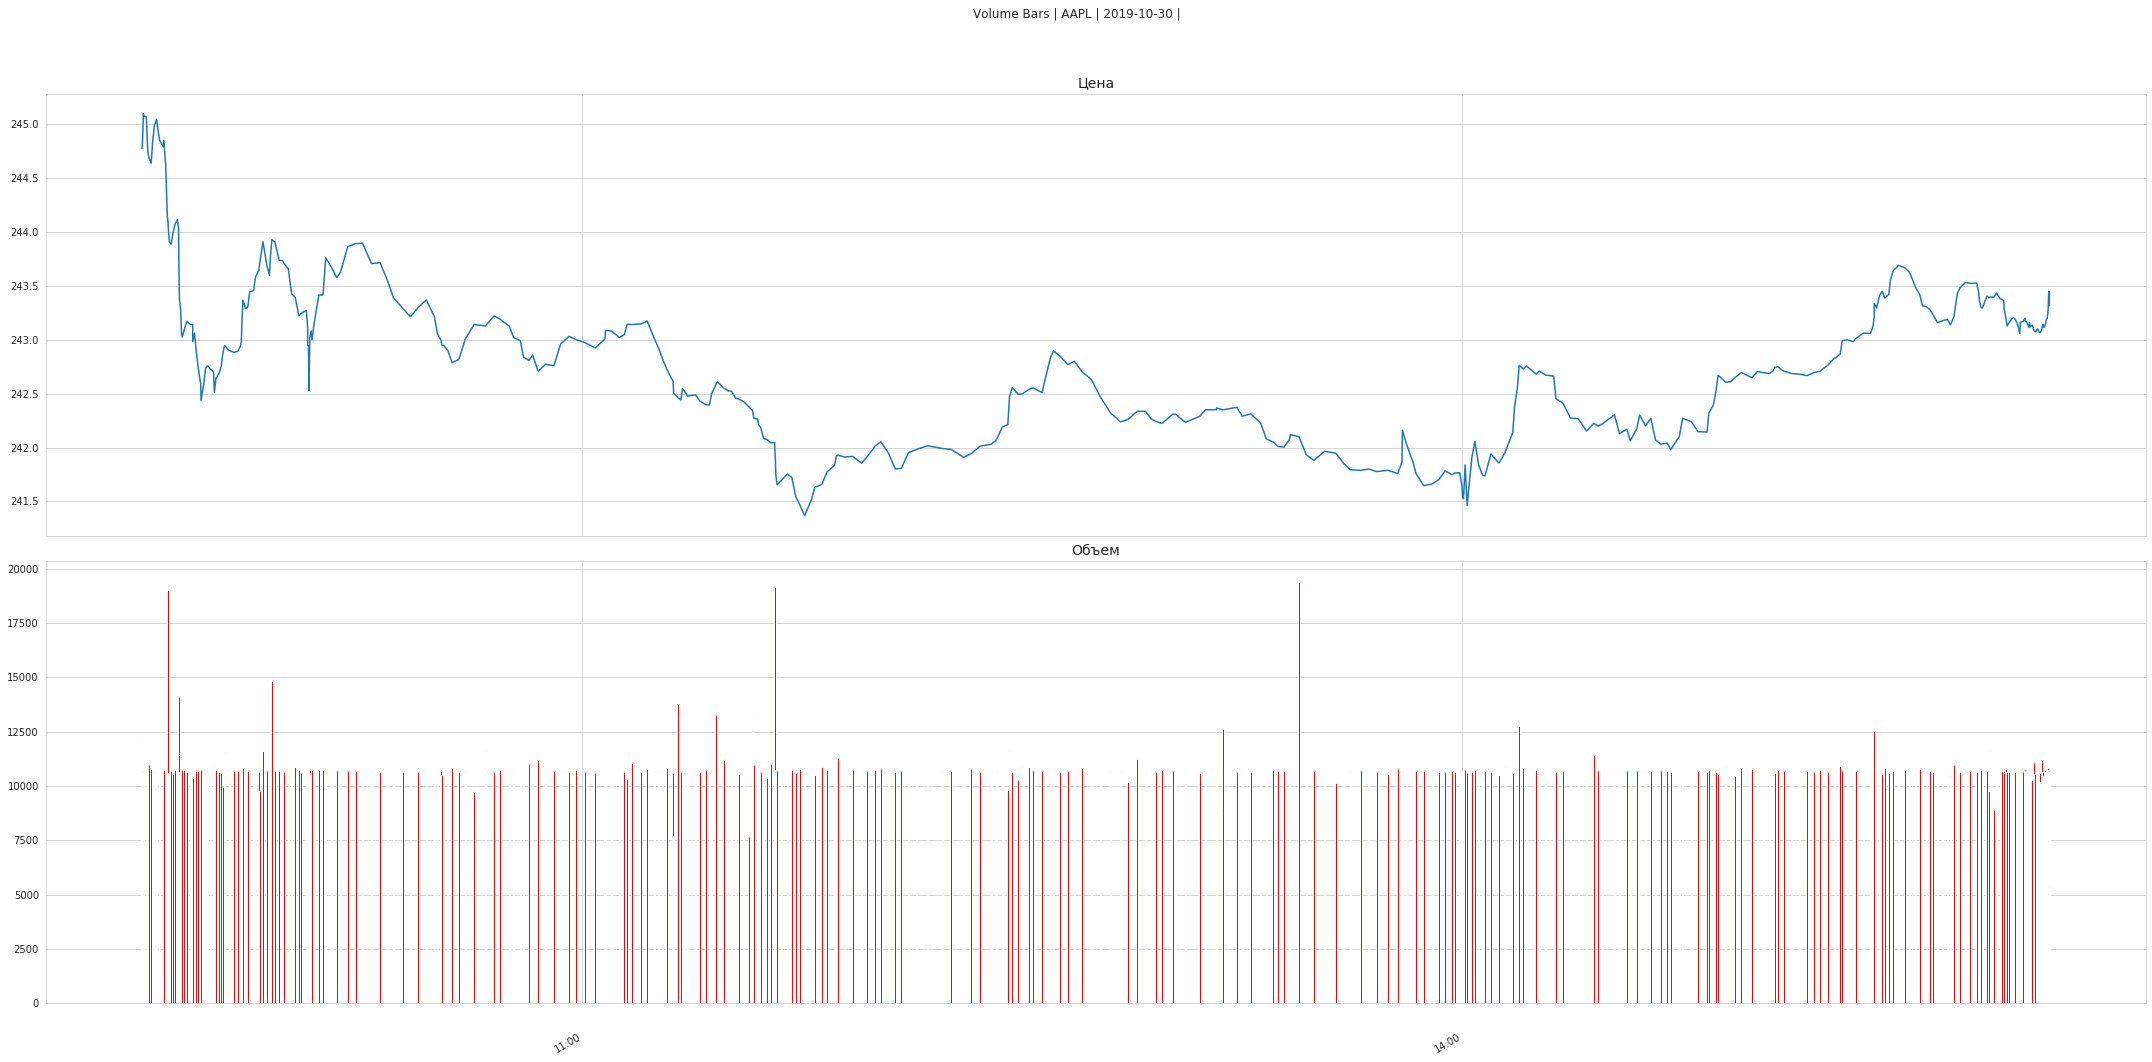

In [62]:
price_volume(vol_bars.set_index('timestamp'), subtitle=f'Volume Bars | {title} |');

In [64]:
normaltest(vol_bars.vwap.dropna())

NormaltestResult(statistic=26.54669921949387, pvalue=1.7197190736584466e-06)

## Dollar Bars


Когда цены на активы значительно изменяются, например, при сплитах - стоимость определенного количества акций изменяется на порядо, что приводить к тому, что Volume Bars отображают это изменение, тем самым затрудняя сравнение показателей за различные периоды. Чтобы уйти от этой проблемы нужно использовать Dollar Bars как произведение объема торгуемых акций на цену акции.

In [67]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)

In [68]:
value_per_min = trades.shares.mul(trades.price).sum() / (60 * 7.5)
trades['cumul_val'] = trades.shares.mul(trades.price).cumsum()

In [70]:
df = trades.reset_index()
by_value = df.groupby(df.cumul_val.div(value_per_min).round().astype(int))
dollar_bars = pd.concat([by_value.timestamp.last().to_frame('timestamp'),
                         get_bar_stats(by_value)], axis=1)
dollar_bars

,timestamp,open,high,low,close,vwap,vol,txn
cumul_val,,,,,,,,
0,2019-10-30 09:30:01.658171058,244.83,244.94,244.72,244.82,244.77,5287,56
1,2019-10-30 09:30:02.124784227,244.82,244.85,244.76,244.77,244.79,9157,45
2,2019-10-30 09:30:04.095544194,244.77,244.96,244.66,244.87,244.80,12047,71
3,2019-10-30 09:30:13.816494419,244.87,245.00,244.87,245.00,244.98,10474,127
4,2019-10-30 09:30:17.522098123,245.00,245.25,245.00,245.13,245.09,10690,116
...,...,...,...,...,...,...,...,...
446,2019-10-30 15:59:50.143251122,243.35,243.43,243.32,243.42,243.39,10743,115
447,2019-10-30 15:59:52.830049012,243.42,243.48,243.38,243.46,243.45,10701,103
448,2019-10-30 15:59:55.074076307,243.46,243.50,243.40,243.42,243.43,9230,90


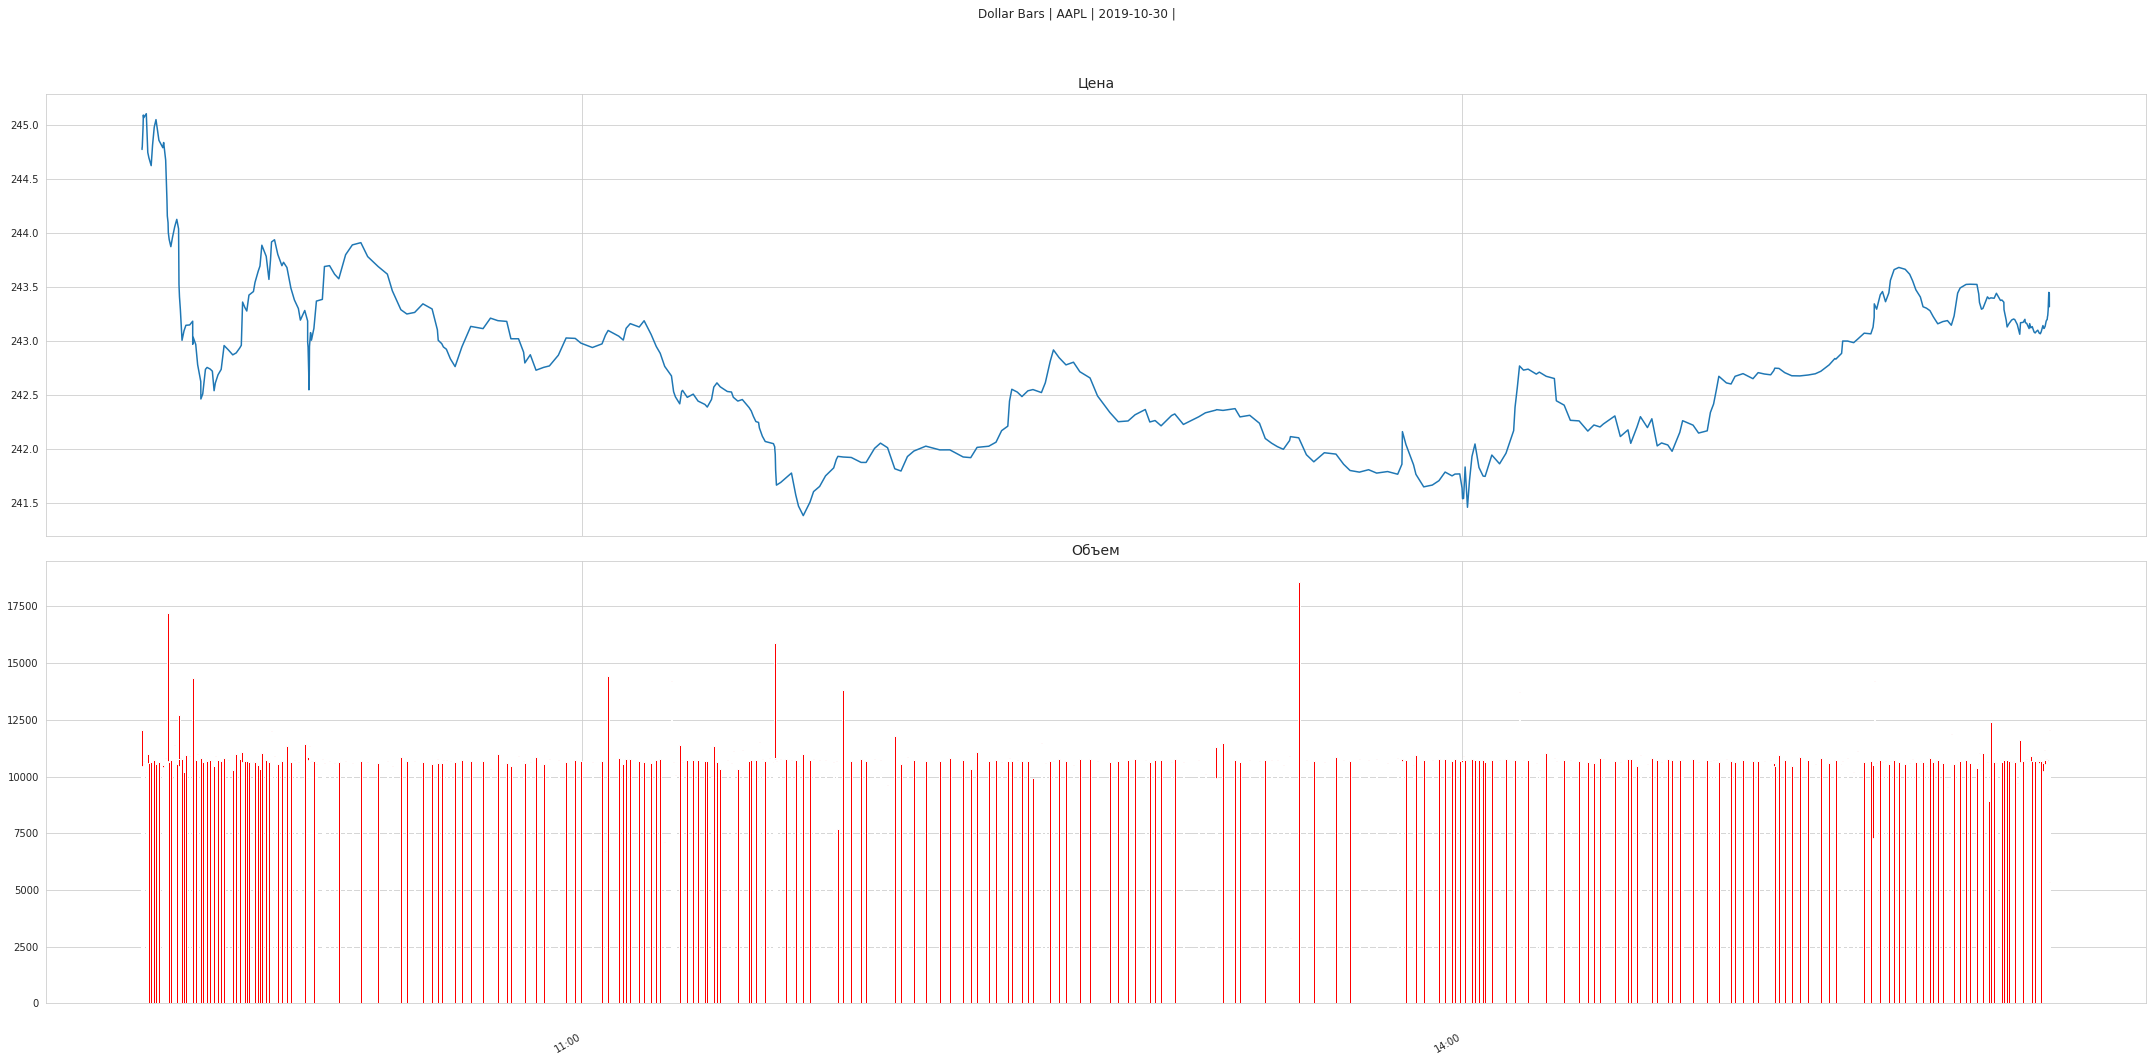

In [71]:
price_volume(dollar_bars.set_index('timestamp'), subtitle=f'Dollar Bars | {title} |');